In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns
import os

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
FIG_PREFIX = 'revision2/sysy'

In [4]:
ALL_METHODS = ['BEST', 'FREE', 'LPMS', 'Trigram', 'VGGraph']

In [5]:
root_dir = '../result/sysy_results_part2/sysy_results/'
# root_free_dir = os.path.join(root_dir, 'enron_free_revision')
# root_best_dir = os.path.join(root_dir, 'enron_best_result4')
# root_lpms_dir = os.path.join(root_dir, 'enron_lpms_result4')
# trigram_dir = os.path.join(root_dir, 'enron_trigram_result')
# vgg_dir = os.path.join(root_dir, 'enron_vggraph_greedy_revision')

id_cols = ['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys']

In [38]:
def build_stats_filename(row, previous_version, reduced):
    name = row['name']
    if 'parallel' in name:
        name = name.split('-')[0]
    if 'VGGraph-Greedy' in name:
        name = 'VGGRAPH'
    fields = [name, str(int(row['num_threads'])), str(int(row['gram_size'])), str(row['selectivity'] if row['selectivity'] > 0 else -1), 'stats.csv']
    if 'Trigram' in name:
        fields[2] = '-1'
    if not previous_version:
        if reduced is not None:
            fields.insert(-1, str(reduced))
        elif 'BEST' in name:
            fields.insert(-1, '-1')
    space_file = f"time_report_"
    if 'LPMS' in name:
        space_file += f"lpms_t{int(row['num_threads'])}"
        space_file += '_determ' if 'DETER' in name else '_random'
        # max_num = -1
    else:
        if 'VGGraph-Greedy' in row['name']:
            space_file += f"{row['name'].lower().replace('-', '_')}_t{int(row['num_threads'])}"
        else:
            space_file += f"{name.lower()}_t{int(row['num_threads'])}"
        if reduced is not None:
            space_file += f"_red{reduced/1000:g}"
        if 'Trigram' not in name:
            space_file += f"_c{row['selectivity']}"
        if 'FREE' in name or 'VG' in name:
            space_file += f"_n{int(row['gram_size'])}"
    if 'key_upper_bound' in row:
        key_upp = int(row['key_upper_bound'])
        if key_upp < 100000000:
            space_file += f"_{key_upp}"
        else:
            space_file += "_-1"
        fields.insert(-1, str(key_upp))
    space_file += '.txt'
    return '_'.join(fields), space_file   

In [36]:
def get_compute_space(space_f, root_dir=root_dir):
    fullname = os.path.join(root_dir, space_f)
    try:
        with open(fullname, 'r') as file:
            for line in file:
                if 'Maximum resident set size (kbytes)' in line:
                    return int(line.strip().split(': ')[-1].strip())
    except:
        print(f'Error reading file {fullname}')
        pass
    return -1

In [8]:
def get_stats_df(row, previous_version=False, reduced=None, root_dir=root_dir):
    fname, space_f = build_stats_filename(row, previous_version, reduced)
    return pd.read_csv(os.path.join(root_dir, fname), sep='\t'), get_compute_space(space_f, root_dir)

In [9]:
def add_num_after_filter(df, previous_version=False, reduced_list=None, root_dir=root_dir):
    new_cols = {
        'num_after_filter': [],
        'per_query_num_after_filter': [],
        'match_count': [],
        'compute_size': []
    }
    idx = 0
    reduced = None
    if reduced_list is not None:
        assert(reduced_list is None or len(reduced_list) == df.shape[0])
    for _, row in df.iterrows():
        if reduced_list is not None:
            reduced = reduced_list[idx]
            idx += 1
        detail_df, compute_size = get_stats_df(row, previous_version, reduced=reduced, root_dir=root_dir)
        new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum())
        new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean())
        new_cols['match_count'].append(detail_df['count'].sum())
        new_cols['compute_size'].append(compute_size)
    return df.assign(**new_cols)

In [10]:
def build_result_df(root_dir, previous_version=False, reduced=None):
    summary_path = os.path.join(root_dir, 'summary.csv')
    summary_df = pd.read_csv(summary_path)
    summary_df.ffill(inplace=True)
    summary_df.fillna(-1, inplace=True)
    summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
    summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
    summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']
    # code for getting end-to-end trimmed mean
    summary_df = add_num_after_filter(summary_df, previous_version=previous_version, reduced_list=reduced, root_dir=root_dir)
    res = summary_df.sort_values('overall_time')
    gb = res.groupby(by=id_cols)
    if gb.count()['selection_time'].min() > 2:
        res = res.drop(gb.tail(1).index)
        res = res.drop(gb.head(1).index)
    res_df = res.groupby(by=id_cols, as_index=False).min(numeric_only=True).apply(lambda x: x)
    return res_df

In [39]:
res_df = build_result_df(root_dir) #pd.concat([res_vgg, res_trigram, res_best_df, res_lpms_df, res_free_df], ignore_index=True)

In [40]:
# explore the distribution of number of keys and number
res_df['prop_error'] = (res_df['num_after_filter'] - res_df['match_count']) / res_df['num_after_filter']
res_df['precision'] = ( res_df['match_count']) / res_df['num_after_filter']
res_df['method'] = [name.split('-')[0] for name in res_df['name']]

In [41]:
res_df['gram_size'] = pd.to_numeric(res_df['gram_size'])

In [42]:
new_res_df = res_df.loc[res_df.groupby(['num_after_filter', 'precision', 'num_keys', 'name']).gram_size.idxmin()].sort_values(by='num_keys')
new_groups = new_res_df.groupby(['name', 'gram_size'])

In [43]:
res_df[res_df.match_time == res_df.match_time.min()]

,name,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,...,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,prop_error,precision,method
12,LPMS-DETERM,16.0,-1.0,-1.0,20.0,20.0,19.0,2174.29,-1.0,2174.29,...,220.823338,220.823679,2395.113679,255146557,1.342877e+07,83755024,104699196,0.671738,0.328262,LPMS


[  5.   6.  10.  20.  25.  50. 100. 125.]


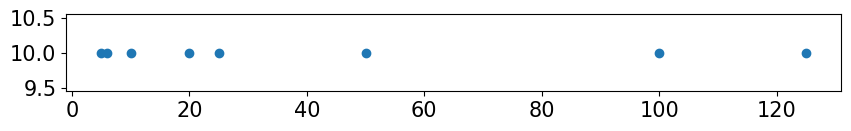

In [45]:
data = np.sort(new_res_df['num_keys'].unique())
print(data)
fig, ax = plt.subplots(figsize=(10, 1))
ax.scatter(data, [10] * len(data))

In [46]:
# decide the split points
def pairwise_difference(lst):
    differences = []
    prec_diffs = []
    for i in range(len(lst) - 1):
        prec_diffs.append((lst[i + 1] - lst[i])/lst[i])
        differences.append(lst[i + 1] - lst[i])
    return differences, prec_diffs
diffs, prec_diffs = pairwise_difference(data)
idxs = np.argsort(diffs)
prec_idxs = np.argsort(prec_diffs)

idx[0], between 5.0 and 6.0
idx[3], between 20.0 and 25.0
idx[6], between 100.0 and 125.0
idx[1], between 6.0 and 10.0
idx[2], between 10.0 and 20.0
idx[4], between 25.0 and 50.0
idx[5], between 50.0 and 100.0


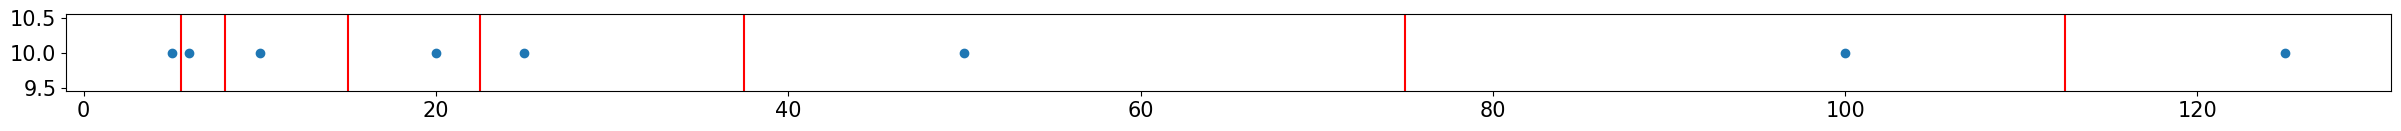

In [47]:
fig, ax = plt.subplots(figsize=(30, 1))
ax.scatter(data, [10] * len(data))
bins = [np.min(data)-1]
for idx in prec_idxs[-9:]:
    print(f'idx[{idx}], between {data[idx]} and {data[idx+1]}')
    curr_x = (data[idx] + data[idx + 1])/2
    bins.append(curr_x)
    ax.axvline(x=curr_x, color='red')
bins = np.sort(bins)
bins = np.append(bins, int(np.max(data)*1.01))

In [48]:
print(bins)

[  4.    5.5   8.   15.   22.5  37.5  75.  112.5 126. ]


In [50]:
name_map = {
    'BEST' : '\\best ',
    'FREE' : '\\free ',
    'FAST' : '\\lpms ',
    'LPMS' : '\\lpms ',
    'Trig' : '\\trigram ',
    'VGGr': '\\vgg '
}

def check_min_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].min():
        curr_str += '& \cellcolor{green!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str

def check_max_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].max():
        curr_str += '& \cellcolor{yellow!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str
summary_df = None

lims = [ 10, 25,150]
for up_lim in lims:
# for up_lim in bins[2:]:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    # curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    curr_group = curr_df.sort_values(by=['precision', 'index_size'], ascending=[False, True]).groupby(['method']).first()
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    # print(curr_group)
    # print(up_lim)
    curr_group['key_upper_bound'] = [up_lim]*curr_group.shape[0]
    curr_group = curr_group.sort_values(by='name')
    count = 0
    curr_row_count = curr_group.shape[0]
    curr_group['max_key'] = [up_lim]*curr_row_count    
    for _, row in curr_group.iterrows():
        curr_str = ''
        count += 1;
        if count == 1:
            curr_str += '\multirow{'+str(curr_row_count)+'}{*}{\\bf{'+ f'{up_lim:.1e}' + '}}'
        curr_str += f'& {name_map[row["name"][:4]]} '

        curr_str += check_min_cell(row, 'overall_match_time', f'{row["overall_match_time"]:.0f}', curr_group)
        curr_str += check_min_cell(row, 'overall_index_time', f'{row["overall_index_time"]:.0f}', curr_group)
        curr_str += check_min_cell(row, 'compute_size', f'{row["compute_size"]/1000000:.0f}', curr_group)
        curr_str += check_min_cell(row, 'index_size', f'{row["index_size"]/1000000:.1f}', curr_group)
        curr_str += check_max_cell(row, 'precision', f'{row["precision"]:.3f}', curr_group)
        print(curr_str, end='')
        if count < curr_row_count:
            print("\\\\ ")
        else:
            print("\\\\ \midrule")
            
    app = []
    for m in ALL_METHODS:
        if m not in curr_group.index:
            app.append({'name': m, 
                        'overall_index_time': 0,
                        'index_size': 0,
                        'compute_size': 0,
                        'precision': 0})
    for a in app:
        curr_group = curr_group.append(a, ignore_index=True)

    if summary_df is None:
        summary_df = curr_group
    else:
        summary_df = pd.concat([summary_df, curr_group], ignore_index=True)
summary_df['name'] = [ nm.split('-')[0] for nm in summary_df['name'].to_list()]

\multirow{3}{*}{\bf{1.0e+01}}& \best  & \cellcolor{green!50}{311} & 24810 & 217 & 351.5 & \cellcolor{yellow!50}{0.143} \\ 
& \free  & 1201 & \cellcolor{green!50}{1324} & \cellcolor{green!50}{43} & \cellcolor{green!50}{0.3} & 0.023 \\ 
& \lpms  & 373 & 2184 & 104 & 2799.0 & 0.113 \\ \midrule
\multirow{3}{*}{\bf{2.5e+01}}& \best  & 254 & 28912 & 219 & 650.6 & 0.216 \\ 
& \free  & 1201 & \cellcolor{green!50}{1324} & \cellcolor{green!50}{43} & \cellcolor{green!50}{0.3} & 0.023 \\ 
& \lpms  & \cellcolor{green!50}{221} & 2174 & 105 & 3360.4 & \cellcolor{yellow!50}{0.328} \\ \midrule
\multirow{3}{*}{\bf{1.5e+02}}& \best  & 254 & 28912 & 219 & \cellcolor{green!50}{650.6} & 0.216 \\ 
& \free  & 332 & \cellcolor{green!50}{947} & \cellcolor{green!50}{88} & 30360.0 & 0.189 \\ 
& \lpms  & \cellcolor{green!50}{221} & 2174 & 105 & 3360.4 & \cellcolor{yellow!50}{0.328} \\ \midrule


In [51]:
overall_df = None
for up_lim in lims: # bins[1:]:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    print(up_lim)
    # print(curr_df.groupby(['method']).precision.idxmax())
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    curr_group['key_upper_bound'] = [up_lim]*curr_group.shape[0]
    app = []
    for m in ALL_METHODS:
        if m not in curr_group.index:
            app.append({'name': m, 
                        'num_keys': up_lim-1,
                        'overall_index_time': 0,
                        'index_size': 0,
                        'compute_size': 0,
                        'precision': 0})
    for a in app:
        curr_group = curr_group.append(a, ignore_index=True)
    if overall_df is None:
        overall_df = curr_group
    else:
        overall_df = overall_df.append(curr_group, ignore_index=True)
overall_df['name'] = [ nm.split('-')[0] for nm in overall_df['name'].to_list()]

10
25
150


In [52]:
overall_df

,name,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,...,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,prop_error,precision
0,BEST,16.0,-1.0,0.1,10.0,10.0,19.0,24810.500,0.049350,24810.500,...,0.000349,311.151875,311.152224,25121.652224,5.845589e+08,3.076626e+07,83755024.0,217236768,0.856721,0.143279
1,FREE,16.0,2.0,0.7,5.0,10.0,0.0,1263.680,60.568900,1324.250,...,0.000340,1200.984178,1200.984526,2525.234526,3.648733e+09,1.920386e+08,83755024.0,42784064,0.977045,0.022955
2,LPMS,16.0,-1.0,-1.0,10.0,10.0,19.0,2184.440,-1.000000,2184.440,...,0.000335,373.323463,373.323809,2557.763809,7.389030e+08,3.888963e+07,83755024.0,104299588,0.886649,0.113351
3,Trigram,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000
4,VGGraph,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000
5,BEST,16.0,-1.0,0.1,25.0,25.0,19.0,28911.300,0.874351,28912.200,...,0.000336,253.829937,253.830278,29166.030278,3.879811e+08,2.042006e+07,83755024.0,218629048,0.784126,0.215874
6,FREE,16.0,2.0,0.7,5.0,25.0,0.0,1263.680,60.568900,1324.250,...,0.000340,1200.984178,1200.984526,2525.234526,3.648733e+09,1.920386e+08,83755024.0,42784064,0.977045,0.022955
7,LPMS,16.0,-1.0,-1.0,20.0,25.0,19.0,2174.290,-1.000000,2174.290,...,0.000333,220.823338,220.823679,2395.113679,2.551466e+08,1.342877e+07,83755024.0,104699196,0.671738,0.328262
8,Trigram,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000
9,VGGraph,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000


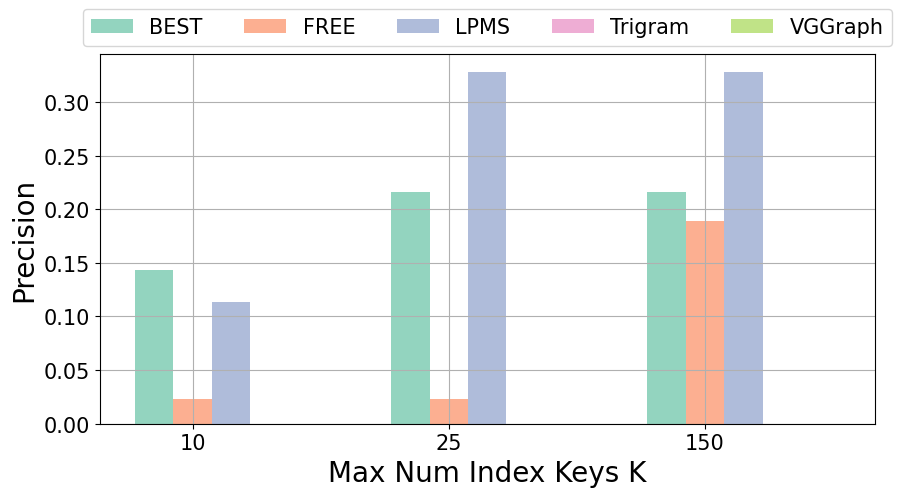

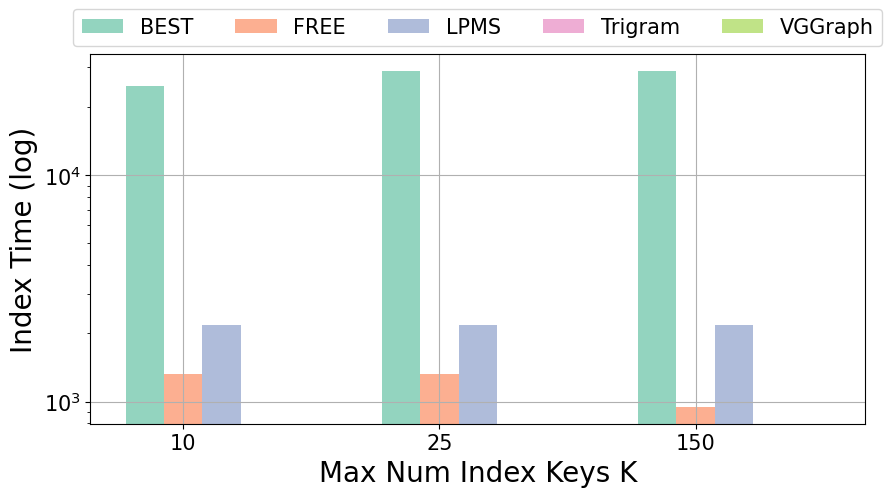

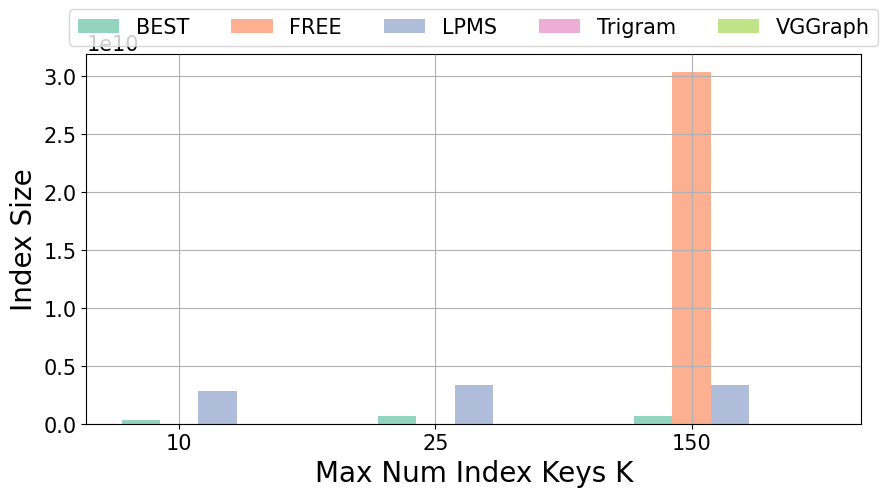

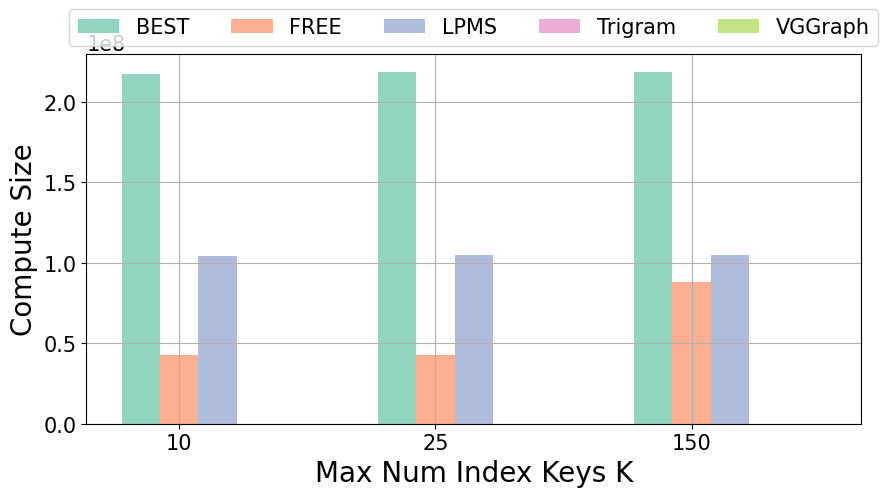

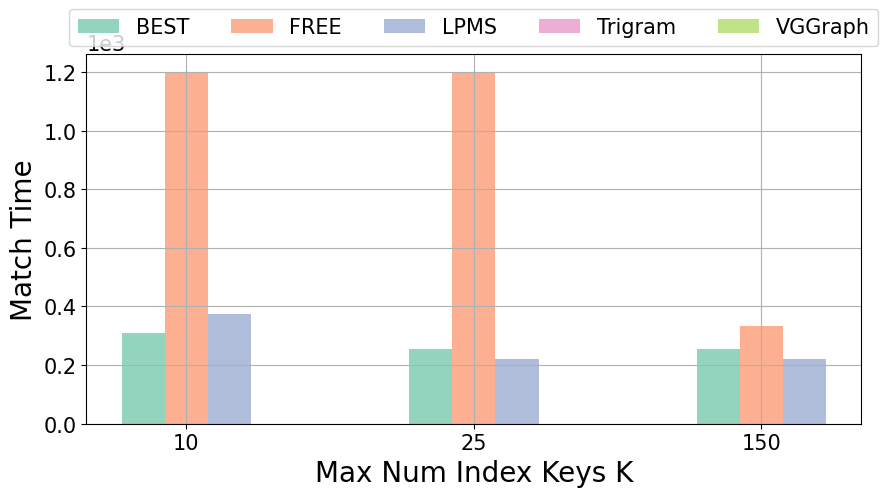

In [53]:
from matplotlib.ticker import ScalarFormatter

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for col in ['precision', 'overall_index_time', 'index_size', 'compute_size', 'overall_match_time']:
    # fig, ax = plt.subplots(figsize=(4,2.8))
    # fig, ax = plt.subplots(figsize=(6,4.2))
    fig, ax = plt.subplots(figsize=(10,4.8))
        
    x = np.arange(len(lims))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0
    for method, color in zip(ALL_METHODS, colors):
        curr = overall_df.loc[overall_df["name"] == method]#.sort_values('name')
        
        X = curr['key_upper_bound']
        
        # fig, ax = plt.subplots(layout='constrained')
        offset = width * multiplier - width
        Y = curr[col].to_numpy()
        rects = ax.bar(x + offset, Y, width, alpha=0.7, label=method, color=color)
        multiplier += 1
        
    ylb = ' '.join([w.capitalize() for w in col.split('_')[-2:]])
    if col == 'overall_index_time':
        ax.set_yscale('log')
        ax.ticklabel_format(axis='x', scilimits=[-3,3])
        ylb += ' (log)'
    else:
        ax.ticklabel_format(scilimits=[-3,3])
    ax.set_ylabel(ylb)
    ax.set_xlabel('Max Num Index Keys K')

    ax.set_xticks(ticks=x, labels=[f'{int(v)}' for v in lims])

    plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
    plt.grid()
    plt.savefig(f'figs/{FIG_PREFIX}_{col}.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)


# Synthetic Workload Analysis

Analysis for synthetic workload data with varying dataset sizes, query sizes, and selectivities.

In [ ]:
# Configuration for synthetic workload analysis
synthetic_root_dir = '../result/synthetic_results/'  # Update this path as needed
synthetic_fig_prefix = 'revision2/synthetic'

# Define the parameter ranges for synthetic workloads
DATASET_SIZES = [1000, 5000, 10000, 50000, 100000]  # Update based on your actual data
QUERY_SIZES = [50, 100, 500, 1000, 2000]  # Update based on your actual data  
SELECTIVITIES = [0.01, 0.05, 0.1, 0.2]  # Update based on your actual data
SYNTHETIC_METHODS = ['BEST', 'FREE', 'LPMS', 'Trigram', 'VGGraph']

In [ ]:
def parse_synthetic_folder_name(folder_name):
    """
    Parse synthetic folder name with format: synthetic2_{datasetSize}_{querySize}_{selectivity}_{methodName}_{suffix}
    Returns a dictionary with parsed parameters or None if parsing fails.
    """
    try:
        parts = folder_name.split('_')
        if len(parts) < 5 or not parts[0].startswith('synthetic'):
            return None
            
        dataset_size = int(parts[1])
        query_size = int(parts[2])
        selectivity = float(parts[3])
        method_name = parts[4]
        suffix = '_'.join(parts[5:]) if len(parts) > 5 else ''
        
        return {
            'dataset_size': dataset_size,
            'query_size': query_size,
            'selectivity': selectivity,
            'method_name': method_name,
            'suffix': suffix,
            'folder_name': folder_name
        }
    except (ValueError, IndexError):
        return None

In [ ]:
def build_synthetic_stats_filename(folder_info, previous_version=False):
    """
    Build the stats filename for synthetic workload based on folder info.
    Adapts the existing build_stats_filename logic for synthetic data.
    """
    method = folder_info['method_name']
    
    # Handle method name variations
    if 'parallel' in method:
        method = method.split('-')[0]
    if 'VGGraph-Greedy' in method:
        method = 'VGGRAPH'
    
    # Basic fields: method, threads, gram_size, selectivity, stats.csv
    # For synthetic, we'll use default values since they may not be in folder name
    fields = [method, '1', '4', str(folder_info['selectivity']), 'stats.csv']  # Default thread=1, gram_size=4
    
    if 'Trigram' in method:
        fields[2] = '-1'  # Trigram doesn't use gram_size
    
    # Space file for memory usage
    space_file = f"time_report_{method.lower()}_t1"
    if 'Trigram' not in method:
        space_file += f"_c{folder_info['selectivity']}"
    if method in ['FREE', 'VGGraph', 'VGGRAPH']:
        space_file += f"_n{fields[2]}"
    space_file += '.txt'
    
    return '_'.join(fields), space_file

In [ ]:
def discover_synthetic_folders(root_dir):
    """
    Discover all synthetic workload folders and parse their parameters.
    Returns a list of folder info dictionaries.
    """
    folder_infos = []
    
    if not os.path.exists(root_dir):
        print(f"Warning: Directory {root_dir} does not exist")
        return folder_infos
    
    for item in os.listdir(root_dir):
        item_path = os.path.join(root_dir, item)
        if os.path.isdir(item_path) and item.startswith('synthetic'):
            folder_info = parse_synthetic_folder_name(item)
            if folder_info:
                folder_infos.append(folder_info)
            else:
                print(f"Warning: Could not parse folder name: {item}")
    
    print(f"Found {len(folder_infos)} synthetic workload folders")
    return folder_infos

In [ ]:
def build_synthetic_result_df(root_dir):
    """
    Build result dataframe for synthetic workloads.
    Adapts the existing build_result_df function for synthetic data structure.
    """
    all_results = []
    folder_infos = discover_synthetic_folders(root_dir)
    
    for folder_info in folder_infos:
        folder_path = os.path.join(root_dir, folder_info['folder_name'])
        summary_path = os.path.join(folder_path, 'summary.csv')
        
        if not os.path.exists(summary_path):
            print(f"Warning: No summary.csv found in {folder_path}")
            continue
            
        try:
            summary_df = pd.read_csv(summary_path)
            summary_df.ffill(inplace=True)
            summary_df.fillna(-1, inplace=True)
            
            # Add synthetic workload parameters
            summary_df['dataset_size'] = folder_info['dataset_size']
            summary_df['query_size'] = folder_info['query_size']
            summary_df['synthetic_selectivity'] = folder_info['selectivity']
            summary_df['method_name'] = folder_info['method_name']
            summary_df['folder_name'] = folder_info['folder_name']
            
            # Calculate derived metrics (same as original)
            summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
            summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
            summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']
            
            # Add detailed stats (adapt existing function)
            try:
                summary_df = add_synthetic_num_after_filter(summary_df, folder_path)
            except Exception as e:
                print(f"Warning: Could not add detailed stats for {folder_info['folder_name']}: {e}")
                # Add default values if stats unavailable
                summary_df['num_after_filter'] = -1
                summary_df['per_query_num_after_filter'] = -1
                summary_df['match_count'] = -1
                summary_df['compute_size'] = -1
            
            all_results.append(summary_df)
            
        except Exception as e:
            print(f"Error processing {folder_path}: {e}")
            continue
    
    if not all_results:
        print("No valid results found")
        return pd.DataFrame()
    
    # Combine all results
    combined_df = pd.concat(all_results, ignore_index=True)
    
    # Apply same processing as original
    id_cols_synthetic = ['name', 'dataset_size', 'query_size', 'synthetic_selectivity', 'method_name']
    res = combined_df.sort_values('overall_time')
    gb = res.groupby(by=id_cols_synthetic)
    
    # Remove outliers if we have enough data points
    if len(all_results) > 0 and gb.count()['selection_time'].min() > 2:
        res = res.drop(gb.tail(1).index)
        res = res.drop(gb.head(1).index)
    
    res_df = res.groupby(by=id_cols_synthetic, as_index=False).min(numeric_only=True).apply(lambda x: x)
    return res_df

In [ ]:
def add_synthetic_num_after_filter(df, folder_path):
    """
    Add detailed stats for synthetic workload.
    Adapts the existing add_num_after_filter function.
    """
    new_cols = {
        'num_after_filter': [],
        'per_query_num_after_filter': [],
        'match_count': [],
        'compute_size': []
    }
    
    for _, row in df.iterrows():
        try:
            # Try to find stats file in the folder
            stats_files = [f for f in os.listdir(folder_path) if f.endswith('_stats.csv')]
            
            if not stats_files:
                # Use default values if no stats file found
                new_cols['num_after_filter'].append(-1)
                new_cols['per_query_num_after_filter'].append(-1)
                new_cols['match_count'].append(-1)
                new_cols['compute_size'].append(-1)
                continue
                
            # Use the first stats file found
            stats_file = stats_files[0]
            detail_df = pd.read_csv(os.path.join(folder_path, stats_file), sep='\t')
            
            # Get compute size from time report if available
            compute_size = -1
            time_files = [f for f in os.listdir(folder_path) if f.startswith('time_report_') and f.endswith('.txt')]
            if time_files:
                compute_size = get_compute_space(time_files[0], folder_path)
            
            new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum() if 'num_after_filter' in detail_df.columns else -1)
            new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean() if 'num_after_filter' in detail_df.columns else -1)
            new_cols['match_count'].append(detail_df['count'].sum() if 'count' in detail_df.columns else -1)
            new_cols['compute_size'].append(compute_size)
            
        except Exception as e:
            print(f"Warning: Error processing stats for row: {e}")
            new_cols['num_after_filter'].append(-1)
            new_cols['per_query_num_after_filter'].append(-1)
            new_cols['match_count'].append(-1)
            new_cols['compute_size'].append(-1)
    
    return df.assign(**new_cols)

In [ ]:
# Load synthetic workload data
print("Loading synthetic workload data...")
synthetic_res_df = build_synthetic_result_df(synthetic_root_dir)

if not synthetic_res_df.empty:
    # Add derived metrics (similar to original analysis)
    synthetic_res_df['prop_error'] = (synthetic_res_df['num_after_filter'] - synthetic_res_df['match_count']) / synthetic_res_df['num_after_filter'].replace(0, 1)
    synthetic_res_df['precision'] = synthetic_res_df['match_count'] / synthetic_res_df['num_after_filter'].replace(0, 1)
    synthetic_res_df['method'] = [name.split('-')[0] for name in synthetic_res_df['method_name']]
    
    print(f"Loaded data for {len(synthetic_res_df)} experiments")
    print(f"Dataset sizes: {sorted(synthetic_res_df['dataset_size'].unique())}")
    print(f"Query sizes: {sorted(synthetic_res_df['query_size'].unique())}")
    print(f"Selectivities: {sorted(synthetic_res_df['synthetic_selectivity'].unique())}")
    print(f"Methods: {sorted(synthetic_res_df['method'].unique())}")
else:
    print("No synthetic workload data found!")

In [ ]:
def analyze_synthetic_by_parameter(df, vary_param, fixed_params, metrics=['precision', 'overall_index_time', 'overall_match_time', 'index_size', 'compute_size']):
    """
    Analyze synthetic workload results by varying one parameter while keeping others fixed.
    
    Args:
        df: DataFrame with synthetic results
        vary_param: Parameter to vary ('dataset_size', 'query_size', or 'synthetic_selectivity')
        fixed_params: Dict with fixed parameter values {param_name: value}
        metrics: List of metrics to analyze
    """
    if df.empty:
        print("No data to analyze")
        return None
    
    # Filter data based on fixed parameters
    filtered_df = df.copy()
    for param, value in fixed_params.items():
        if param in filtered_df.columns:
            filtered_df = filtered_df[filtered_df[param] == value]
    
    if filtered_df.empty:
        print(f"No data found for fixed parameters: {fixed_params}")
        return None
    
    print(f"Analyzing {len(filtered_df)} experiments varying {vary_param}")
    print(f"Fixed parameters: {fixed_params}")
    print(f"Varying {vary_param}: {sorted(filtered_df[vary_param].unique())}")
    
    # Group by varying parameter and method, take best result for each
    grouped_df = filtered_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby([vary_param, 'method']).first().reset_index()
    
    return grouped_df

In [ ]:
def plot_synthetic_analysis(grouped_df, vary_param, fixed_params, metrics=['precision', 'overall_index_time', 'overall_match_time', 'index_size', 'compute_size']):
    """
    Create plots for synthetic workload analysis.
    """
    if grouped_df is None or grouped_df.empty:
        print("No data to plot")
        return
    
    colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
    available_methods = sorted(grouped_df['method'].unique())
    
    for metric in metrics:
        if metric not in grouped_df.columns:
            print(f"Warning: Metric {metric} not found in data")
            continue
            
        fig, ax = plt.subplots(figsize=(10, 4.8))
        
        for i, method in enumerate(available_methods):
            method_data = grouped_df[grouped_df['method'] == method].sort_values(vary_param)
            
            if not method_data.empty:
                x_vals = method_data[vary_param]
                y_vals = method_data[metric]
                
                # Filter out invalid values
                valid_mask = (y_vals >= 0) & (y_vals.notna())
                x_vals = x_vals[valid_mask]
                y_vals = y_vals[valid_mask]
                
                if len(x_vals) > 0:
                    color = colors[i % len(colors)]
                    ax.plot(x_vals, y_vals, 'o-', label=method, color=color, alpha=0.7, linewidth=2, markersize=6)
        
        # Format plot
        ylabel = ' '.join([w.capitalize() for w in metric.split('_')[-2:]])
        if metric == 'overall_index_time':
            ax.set_yscale('log')
            ylabel += ' (log)'
        
        ax.set_ylabel(ylabel)
        ax.set_xlabel(' '.join([w.capitalize() for w in vary_param.split('_')]))
        
        # Create title with fixed parameters
        fixed_str = ', '.join([f"{k.replace('_', ' ').title()}={v}" for k, v in fixed_params.items()])
        ax.set_title(f'{ylabel} vs {vary_param.replace("_", " ").title()}\n({fixed_str})')
        
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        
        # Save plot
        plot_name = f"{synthetic_fig_prefix}_{vary_param}_{metric}_{'_'.join([f'{k}{v}' for k, v in fixed_params.items()])}"
        plt.savefig(f'figs/{plot_name}.pdf', bbox_inches='tight')
        plt.show()

## Analysis 1: Varying Dataset Size

Fix query size and selectivity, vary dataset size to see scalability.

In [ ]:
if not synthetic_res_df.empty:
    # Example: Fix query_size=1000, selectivity=0.1, vary dataset_size
    fixed_params_1 = {'query_size': 1000, 'synthetic_selectivity': 0.1}
    
    # Check what values are actually available
    available_query_sizes = sorted(synthetic_res_df['query_size'].unique())
    available_selectivities = sorted(synthetic_res_df['synthetic_selectivity'].unique())
    
    print("Available query sizes:", available_query_sizes)
    print("Available selectivities:", available_selectivities)
    
    # Use the most common or middle values if our defaults aren't available
    if 1000 not in available_query_sizes and available_query_sizes:
        fixed_params_1['query_size'] = available_query_sizes[len(available_query_sizes)//2]
    if 0.1 not in available_selectivities and available_selectivities:
        fixed_params_1['synthetic_selectivity'] = available_selectivities[len(available_selectivities)//2]
    
    print(f"Using fixed parameters: {fixed_params_1}")
    
    grouped_dataset = analyze_synthetic_by_parameter(
        synthetic_res_df, 
        vary_param='dataset_size', 
        fixed_params=fixed_params_1
    )
    
    if grouped_dataset is not None:
        plot_synthetic_analysis(grouped_dataset, 'dataset_size', fixed_params_1)
else:
    print("No synthetic data available for dataset size analysis")

## Analysis 2: Varying Query Size

Fix dataset size and selectivity, vary query size to see query scalability.

In [ ]:
if not synthetic_res_df.empty:
    # Example: Fix dataset_size=10000, selectivity=0.1, vary query_size
    available_dataset_sizes = sorted(synthetic_res_df['dataset_size'].unique())
    
    fixed_params_2 = {'dataset_size': 10000, 'synthetic_selectivity': 0.1}
    
    # Use available values if defaults aren't present
    if 10000 not in available_dataset_sizes and available_dataset_sizes:
        fixed_params_2['dataset_size'] = available_dataset_sizes[len(available_dataset_sizes)//2]
    if 0.1 not in available_selectivities and available_selectivities:
        fixed_params_2['synthetic_selectivity'] = available_selectivities[len(available_selectivities)//2]
    
    print(f"Using fixed parameters: {fixed_params_2}")
    
    grouped_query = analyze_synthetic_by_parameter(
        synthetic_res_df, 
        vary_param='query_size', 
        fixed_params=fixed_params_2
    )
    
    if grouped_query is not None:
        plot_synthetic_analysis(grouped_query, 'query_size', fixed_params_2)
else:
    print("No synthetic data available for query size analysis")

## Analysis 3: Varying Selectivity

Fix dataset size and query size, vary selectivity to see impact of query difficulty.

In [ ]:
if not synthetic_res_df.empty:
    # Example: Fix dataset_size=10000, query_size=1000, vary selectivity
    fixed_params_3 = {'dataset_size': 10000, 'query_size': 1000}
    
    # Use available values if defaults aren't present
    if 10000 not in available_dataset_sizes and available_dataset_sizes:
        fixed_params_3['dataset_size'] = available_dataset_sizes[len(available_dataset_sizes)//2]
    if 1000 not in available_query_sizes and available_query_sizes:
        fixed_params_3['query_size'] = available_query_sizes[len(available_query_sizes)//2]
    
    print(f"Using fixed parameters: {fixed_params_3}")
    
    grouped_selectivity = analyze_synthetic_by_parameter(
        synthetic_res_df, 
        vary_param='synthetic_selectivity', 
        fixed_params=fixed_params_3
    )
    
    if grouped_selectivity is not None:
        plot_synthetic_analysis(grouped_selectivity, 'synthetic_selectivity', fixed_params_3)
else:
    print("No synthetic data available for selectivity analysis")

## Summary Analysis

Overall comparison across all synthetic workload configurations.

In [ ]:
if not synthetic_res_df.empty:
    # Overall summary statistics
    print("=== Synthetic Workload Summary ===")
    print(f"Total configurations analyzed: {len(synthetic_res_df)}")
    print(f"Methods tested: {sorted(synthetic_res_df['method'].unique())}")
    print(f"Dataset size range: {synthetic_res_df['dataset_size'].min()} - {synthetic_res_df['dataset_size'].max()}")
    print(f"Query size range: {synthetic_res_df['query_size'].min()} - {synthetic_res_df['query_size'].max()}")
    print(f"Selectivity range: {synthetic_res_df['synthetic_selectivity'].min():.3f} - {synthetic_res_df['synthetic_selectivity'].max():.3f}")
    
    # Method comparison across all configurations
    print("\n=== Method Performance Summary ===")
    method_summary = synthetic_res_df.groupby('method').agg({
        'precision': ['mean', 'std', 'min', 'max'],
        'overall_index_time': ['mean', 'std', 'min', 'max'],
        'overall_match_time': ['mean', 'std', 'min', 'max'],
        'index_size': ['mean', 'std', 'min', 'max'],
        'compute_size': ['mean', 'std', 'min', 'max']
    }).round(3)
    
    print(method_summary)
    
    # Best method for each metric
    print("\n=== Best Method by Metric ===")
    metrics = ['precision', 'overall_index_time', 'overall_match_time', 'index_size', 'compute_size']
    best_methods = {}
    
    for metric in metrics:
        if metric in synthetic_res_df.columns:
            if metric == 'precision':
                best_idx = synthetic_res_df.groupby('method')[metric].mean().idxmax()
                best_val = synthetic_res_df.groupby('method')[metric].mean().max()
            else:
                # For time and size metrics, lower is better
                valid_data = synthetic_res_df[synthetic_res_df[metric] > 0]
                if not valid_data.empty:
                    best_idx = valid_data.groupby('method')[metric].mean().idxmin()
                    best_val = valid_data.groupby('method')[metric].mean().min()
                else:
                    best_idx, best_val = "N/A", "N/A"
            
            best_methods[metric] = (best_idx, best_val)
            print(f"{metric}: {best_idx} ({best_val})")
else:
    print("No synthetic data available for summary analysis")

## Instructions for Customization

To use this analysis with your specific synthetic workload data:

1. **Update the path**: Change `synthetic_root_dir` to point to your results directory
2. **Verify folder naming**: Ensure your folders follow the pattern `synthetic2_{datasetSize}_{querySize}_{selectivity}_{methodName}_{suffix}`
3. **Update parameter ranges**: Modify the lists in the configuration section to match your actual data:
   - `DATASET_SIZES`
   - `QUERY_SIZES` 
   - `SELECTIVITIES`
   - `SYNTHETIC_METHODS`
4. **Customize fixed parameters**: In each analysis section, adjust the `fixed_params` dictionaries to use values that exist in your data
5. **Add more analyses**: Create additional analysis sections by calling `analyze_synthetic_by_parameter()` and `plot_synthetic_analysis()` with different parameter combinations

The code will automatically discover available folders and adapt to the actual parameter values found in your data.